# **Модель прогнозирования ухода клиента** 

**Цель:** прогноз оттока клиентов оператора связи, с целью их удержания (предложения промокодов и специальных условий).

**Задача:** разработать прототип модели, которая подскажет, с кем из клиентов следует поработать над удержанием. Построить модель с показателем метрики ROC_AUC >= 0.85. 

**Описание услуг оператора:**

Оператор предоставляет несколько типов услуг:

- Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

**Описание данных:**

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Данные:**

- [contract_new.csv](https://code.s3.yandex.net/datasets/contract_new.csv)
- [personal_new.csv](https://code.s3.yandex.net/datasets/personal_new.csv)
- [internet_new.csv](https://code.s3.yandex.net/datasets/internet_new.csv)
- [phone_new.csv](https://code.s3.yandex.net/datasets/phone_new.csv)

**Значение столбцов:**

- customerID - идентификатор договора
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания пользования услугами
- Type - тип оплаты: ежемесячный, годовой и тд
- PaperlessBilling - безналичный расчет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего потрачено денег на услуги
- InternetService - Интернет-сервис
- OnlineSecurity - Онлайновая безопасность
- OnlineBackup - Онлайновая резервная копия
- DeviceProtection - Защита устройства
- TechSupport - техподдержка
- StreamingTV - Потоковое телевидение
- StreamingMovies - Потоковые фильмы
- gender - пол
- SeniorCitizen - Пожилой гражданин
- Partner - Партнер
- Dependents - наличие иждивенцев
- MultipleLines - возможность параллельных линий во время разговора  

**План (основные шаги, описание работы):**

1. Чтение файлов с данными.
- Обзор статистик
- Изучение общей информаций.
2. Предобработка данных. 
- Поиск и обработка пропусков, дубликатов.
- Приведение данных к нужному типу.
3. Исследовательский анализ данных. 
- Проверка на выбросы и аномалии.
- Изучение распределения целевого признака.
- Проверка мультиколлинеарности признаков и корреляции с таргетом. 
- Изучение информации зависимостей периода пользования услугами от времени ухода клиента, общее описание ушедшего клиента. 
- Построение графиков.
4. Подготовка признаков для обучения моделей. Разделение данных на выборки. Кодирование.
5. Обучение моделей.
6. Подбор гиперпараметров (на кроссвалидации). Выбор лучшей модели (по метрике на кроссвалидации). Тестирование.
7. Исследование важности признаков.
8. Результаты и общие выводы.

**План (проект):** 

- Обзор данных.
- Предобработка данных.
- Исследовательский анализ данных.
- Обучение моделей.
- Тестирование.
- Общие выводы.

Целевой признак: столбец 'EndDate'
Основная метрика: ROC-AUC.


## Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import seaborn as sns

from IPython.display import display
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

In [2]:
RANDOM_STATE = 220523
warnings.filterwarnings("ignore")

In [3]:
def info_df(df):
    print ('Название: ',df.name)
    print ('Размер: ' , df.shape)
    print('Пропущенных значений:  ', df.isnull().sum().values.sum())
    print('\n')
    print('Уникальных значений:  \n', df.nunique())
    print("\n")
    print(df.info())
    display(df.sample(5))
    print()
    display(df.describe())

In [4]:
try:
    data = pd.read_csv('insurance.csv')
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
contract.name = 'contract'
internet.name = 'internet'
personal.name = 'personal'
phone.name = 'phone'

### Обзор данных contract — информация о договоре

In [6]:
info_df(contract)

Название:  contract
Размер:  (7043, 8)
Пропущенных значений:   0


Уникальных значений:  
 customerID          7043
BeginDate             77
EndDate               67
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


customerID   BeginDate     EndDate            Type PaperlessBilling  \
1163  0135-NMXAP  2018-11-01          No  Month-to-month              Yes   
373   2805-EDJPQ  2015-06-01          No        One year              Yes   
1290  3108-PCCGG  2014-02-01          No        Two year               No   
1202  3927-NLNRY  2015-07-01  2019-10-01        One year              Yes   
1302  3230-IUALN  2016-05-01          No        Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
1163  Bank transfer (automatic)           89.75      1359.71  
373     Credit card (automatic)           99.75      5809.44  
1290    Credit card (automatic)           84.45       6080.4  
1202  Bank transfer (automatic)           94.25      5095.16  
1302               Mailed check           81.00       3645.0

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

Итак, основной исходный файл с информацией о договоре содержит 7043 строк и 8 столбцов. 
- Пропусков нет. 
- Необходимо изменить тип данных в следующих колонках: BeginDate, EndDate, TotalCharges. 
- Есть аномальные значения. No в строках с датой окончания пользования услугами EndDate. Т.е. можно сделать вывод, что клиент еще является пользователем услуг оператора.

### Обзор данных personal —  персональные данные клиента

In [7]:
info_df(personal)

Название:  personal
Размер:  (7043, 5)
Пропущенных значений:   0


Уникальных значений:  
 customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


customerID  gender  SeniorCitizen Partner Dependents
2801  1017-FBQMM  Female              0     Yes        Yes
6296  4023-RTIQM  Female              1     Yes         No
4075  3160-TYXLT    Male              0      No         No
3341  1125-SNVCK  Female              1      No         No
1942  3764-MNMOI    Male              0      No         No

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

Оценим кол-во клиентов по возрасту, полу, семейному положению и детям.

Text(0, 0.5, 'Кол-во')

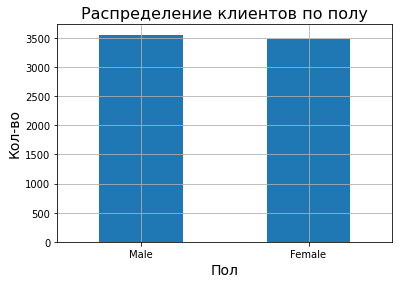

In [8]:
personal["gender"].value_counts().plot.bar(rot=0, grid=True)
plt.title("Распределение клиентов по полу", fontsize=16)
plt.xlabel("Пол", fontsize=14)
plt.ylabel("Кол-во", fontsize=14)

Text(0, 0.5, 'Кол-во')

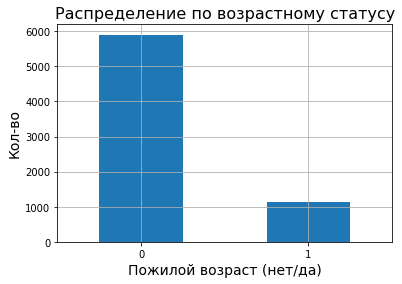

In [9]:
personal["SeniorCitizen"].value_counts().plot.bar(rot=0, grid=True)
plt.title("Распределение по возрастному статусу", fontsize=16)
plt.xlabel("Пожилой возраст (нет/да)", fontsize=14)
plt.ylabel("Кол-во", fontsize=14)

Text(0, 0.5, 'Кол-во')

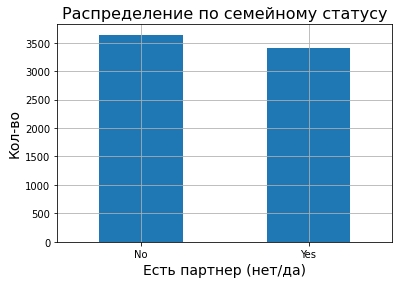

In [10]:
personal["Partner"].value_counts().plot.bar(rot=0, grid=True)
plt.title("Распределение по семейному статусу", fontsize=16)
plt.xlabel("Есть партнер (нет/да)", fontsize=14)
plt.ylabel("Кол-во", fontsize=14)

Text(0, 0.5, 'Кол-во')

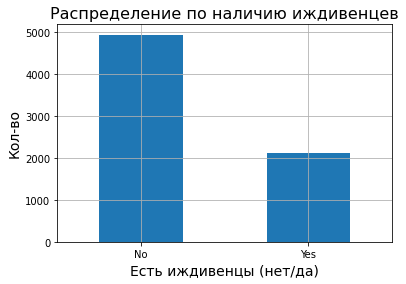

In [11]:
personal["Dependents"].value_counts().plot.bar(rot=0, grid=True)
plt.title("Распределение по наличию иждивенцев", fontsize=16)
plt.xlabel("Есть иждивенцы (нет/да)", fontsize=14)
plt.ylabel("Кол-во", fontsize=14)

Данные состоят из 4 колонок и 7043 строк
Пропусков в данных нет. В целом, пропорции по признакам кол-ва клиентов по возрасту, полу, семейному положению и детям стандартные и однотипные. Особенностей нет. Возможно и не будут иметь важный вес при прогнозировании расторжения договора.

### Обзор данных internet —  информация об интернет-услугах

In [12]:
info_df(internet)

Название:  internet
Размер:  (5517, 8)
Пропущенных значений:   0


Уникальных значений:  
 customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
65    2673-CXQEU     Fiber optic            Yes          Yes              Yes   
4487  1371-WEPDS             DSL             No           No               No   
4741  9526-BIHHD             DSL            Yes           No               No   
2978  9773-PEQBZ     Fiber optic             No          Yes               No   
611   4718-DHSMV             DSL             No           No               No   

     TechSupport StreamingTV StreamingMovies  
65            No         Yes             Yes  
4487          No          No             Yes  
4741          No          No              No  
2978          No          No              No  
611           No         Yes              No

customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     2869-ADAWR     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

Данные сотоят из 7 колонок и 5517 строк.
Датасет содержит меньшее кол-во строк, что говорит о том, что данные есть не по всем клиентам. Да, можно сделать вывод, что не все клиенты пользуются интернет-услугами.

### Обзор данных phone —  информация об услугах телефонии

In [13]:
info_df(phone)

Название:  phone
Размер:  (6361, 2)
Пропущенных значений:   0


Уникальных значений:  
 customerID       6361
MultipleLines       2
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


customerID MultipleLines
5604  3413-CSSTH           Yes
4730  5018-HEKFO           Yes
4766  4393-GEADV           Yes
1028  8257-RZAHR           Yes
5633  7162-WPHPM           Yes

customerID MultipleLines
count         6361          6361
unique        6361             2
top     8098-TDCBU            No
freq             1          3390

Данные состоят из 1 колонки и 6361 строк.
Датасет, как и internet, содержит меньшее кол-во строк. Не все пользуются услугами.

**Вывод**

Изучив первичную информацию по датасетам, можно сделать вывод, что в целом, информации достаточно, янвных пропусков, дубликатов нет. Есть важные для дальнейшего обучения данные по столбцам BeginDate - дата начала пользования услугами и 
EndDate - дата окончания пользования услугами. Есть значения No в дате окончания пользования услугами. 

Важна и замена в дальнейшем типов данных в нескольких колонках. BeginDate, EndDate, TotalCharges (формат dt и числовой тип).

Отметим то, что по столбцу с customerID, который есть во всех таблицах при соответствии одной записи будем объединять данные.

По первичному обзору данных также заметно, что Интернет-услугами и телефониией пользуются не все пользователи, заключившие договор. Основная работа с признаками и зависимрстями на этапе предобработки и исследовательском анализе.

## Предобработка данных

Изначально, для соблюдения стандартов написания кода, приведем наименования столбцов во всех датафреймах к требованиям PEP8.

In [14]:
contract = contract.rename(columns={'customerID': 'customer_id',
                                          'BeginDate': 'begin_date',
                                          'EndDate': 'end_date',
                                          'Type': 'type',
                                          'PaperlessBilling': 'paperless_billing',
                                          'MonthlyCharges': 'monthly_charges',
                                          'PaymentMethod': 'payment_method',
                                          'TotalCharges': 'total_charges'})

In [15]:
personal = personal.rename(columns={'customerID': 'customer_id',
                                          'gender': 'gender',
                                          'SeniorCitizen': 'senior_citizen',
                                          'Partner': 'partner',
                                          'Dependents': 'dependents'})

In [16]:
phone = phone.rename(columns={'customerID': 'customer_id',
                                          'MultipleLines': 'multiple_lines'})

In [17]:
internet = internet.rename(columns={'customerID': 'customer_id',
                                          'InternetService': 'internet_service',
                                          'OnlineSecurity': 'online_security',
                                          'OnlineBackup': 'online_backup',
                                          'DeviceProtection': 'device_protection',
                                          'TechSupport': 'tech_support',
                                          'StreamingTV': 'streaming_tv',
                                          'StreamingMovies': 'streaming_movies'})

Добавим новый стобец Churn - отток абонентов, который будет целевым признаком. Т.е. важны зафиксированные данные факта ухода клиента от оператора, это столбец EndDate. 

In [18]:
contract['сhurn'] = (contract['end_date'] != 'No').astype(int)

In [19]:
contract.head()

customer_id  begin_date end_date            type paperless_billing  \
0  7590-VHVEG  2020-01-01       No  Month-to-month               Yes   
1  5575-GNVDE  2017-04-01       No        One year                No   
2  3668-QPYBK  2019-10-01       No  Month-to-month               Yes   
3  7795-CFOCW  2016-05-01       No        One year                No   
4  9237-HQITU  2019-09-01       No  Month-to-month               Yes   

              payment_method  monthly_charges total_charges  сhurn  
0           Electronic check            29.85         31.04      0  
1               Mailed check            56.95       2071.84      0  
2               Mailed check            53.85        226.17      0  
3  Bank transfer (automatic)            42.30        1960.6      0  
4           Electronic check            70.70         353.5      0

В данном случае будет логично заменим значения no в столбце на актуальную дату выгрузки - 01.02.2020. И заменит тип данных.

In [20]:
contract['end_date'] = contract['end_date'].where(contract['end_date'] != 'No', '2020-02-01')
contract['end_date'] = pd.to_datetime(contract['end_date'])

Заменим и тип данных в столбце begin_date - дата начала пользования услугами.

In [21]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'])

Проверим данные столбца total_charges - кол-во затрат на услуги.

In [22]:
contract['total_charges'].value_counts().sort_index()

          11
100.17     1
100.19     1
100.2      1
100.24     1
          ..
997.05     1
997.78     1
998.89     1
999.6      2
999.9      1
Name: total_charges, Length: 6658, dtype: int64

In [23]:
contract.query('total_charges == " "')

customer_id begin_date   end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year               Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year                No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year                No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year                No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year                No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year                No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year                No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year                No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year               Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year                No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year               Yes   

                 payment_method  monthly_charges total_charges  сhurn  
488   Bank transfer (automatic)            52.55                    0  
753                Mailed check            20.25                    0  
936                Mailed check            80.85                    0  
1082               Mailed check            25.75                    0  
1340    Credit card (automatic)            56.05                    0  
3331               Mailed check            19.85                    0  
3826               Mailed check            25.35                    0  
4380               Mailed check            20.00                    0  
5218               Mailed check            19.70                    0  
6670               Mailed check            73.35                    0  
6754  Bank transfer (automatic)            61.90                    0

Пропуски по клиентам только заключившим договор. Затраты отсутствовали. Можно заменить на 0.

In [24]:
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = 0
contract['total_charges'] = contract['total_charges'].astype(float)

In [25]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   сhurn              7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


Объединим данные

In [26]:
data = contract.merge(internet, how='left', left_on = 'customer_id', right_on = 'customer_id')\
                    .merge(personal, how='left', left_on = 'customer_id', right_on = 'customer_id')\
                    .merge(phone, how='left', left_on = 'customer_id', right_on = 'customer_id')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   сhurn              7043 non-null   int64         
 9   internet_service   5517 non-null   object        
 10  online_security    5517 non-null   object        
 11  online_backup      5517 non-null   object        
 12  device_protection  5517 non-null   object        
 13  tech_support       5517 non-null   object        
 14  streamin

Заменим данные по возрасту на категориальные

In [28]:
data['senior_citizen'] = data['senior_citizen'].replace({1:'Yes', 0:'No'})

In [29]:
data.head()

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year                No   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges  сhurn  \
0           Electronic check            29.85          31.04      0   
1               Mailed check            56.95        2071.84      0   
2               Mailed check            53.85         226.17      0   
3  Bank transfer (automatic)            42.30        1960.60      0   
4           Electronic check            70.70         353.50      0   

  internet_service  ... online_backup device_protection tech_support  \
0              DSL  ...           Yes                No           No   
1              DSL  ...            No               Yes           No   
2              DSL  ...           Yes                No           No   
3              DSL  ...            No               Yes          Yes   
4      Fiber optic  ...            No                No           No   

  streaming_tv streaming_movies  gender senior_citizen partner dependents  \
0           No               No  Female             No     Yes         No   
1           No               No    Male             No      No         No   
2           No               No    Male             No      No         No   
3           No               No    Male             No      No         No   
4           No               No  Female             No      No         No   

  multiple_lines  
0            NaN  
1             No  
2             No  
3            NaN  
4             No  

[5 rows x 21 columns]

In [30]:
data = data.set_index('customer_id')

Как было замечено ранее, есть не все данные по использованию интернета и телефонии, их меньше, появились пропуски.

Заменим пропуски на No. Проверим результат.

In [31]:
data = data.fillna('No')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   сhurn              7043 non-null   int64         
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14

Размер полученного датасета - 7043, 20.

Для правильного обучения модели необходим признак длительности догороров клиента с оператором. Рассчитаем разницу между датой начала договора и датой окончания (в днях). Переменная - total_days.

In [33]:
data['total_days'] = (data['end_date'] - data['begin_date']).dt.days

In [34]:
data.head()

begin_date   end_date            type paperless_billing  \
customer_id                                                           
7590-VHVEG  2020-01-01 2020-02-01  Month-to-month               Yes   
5575-GNVDE  2017-04-01 2020-02-01        One year                No   
3668-QPYBK  2019-10-01 2020-02-01  Month-to-month               Yes   
7795-CFOCW  2016-05-01 2020-02-01        One year                No   
9237-HQITU  2019-09-01 2020-02-01  Month-to-month               Yes   

                        payment_method  monthly_charges  total_charges  сhurn  \
customer_id                                                                     
7590-VHVEG            Electronic check            29.85          31.04      0   
5575-GNVDE                Mailed check            56.95        2071.84      0   
3668-QPYBK                Mailed check            53.85         226.17      0   
7795-CFOCW   Bank transfer (automatic)            42.30        1960.60      0   
9237-HQITU            Electronic check            70.70         353.50      0   

            internet_service online_security  ... device_protection  \
customer_id                                   ...                     
7590-VHVEG               DSL              No  ...                No   
5575-GNVDE               DSL             Yes  ...               Yes   
3668-QPYBK               DSL             Yes  ...                No   
7795-CFOCW               DSL             Yes  ...               Yes   
9237-HQITU       Fiber optic              No  ...                No   

            tech_support streaming_tv streaming_movies  gender senior_citizen  \
customer_id                                                                     
7590-VHVEG            No           No               No  Female             No   
5575-GNVDE            No           No               No    Male             No   
3668-QPYBK            No           No               No    Male             No   
7795-CFOCW           Yes           No               No    Male             No   
9237-HQITU            No           No               No  Female             No   

            partner dependents multiple_lines total_days  
customer_id                                               
7590-VHVEG      Yes         No             No         31  
5575-GNVDE       No         No             No       1036  
3668-QPYBK       No         No             No        123  
7795-CFOCW       No         No             No       1371  
9237-HQITU       No         No             No        153  

[5 rows x 21 columns]

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   сhurn              7043 non-null   int64         
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14

**Вывод**

Данные готовы к исследованию. Так на этапе предобработки, преобразовали названия признаков, столбцов, привели данные  BeginDate, EndDate, TotalCharges к нужным типам. Добавлено 2 новых стобеца **сhurn** - отток абонентов, который будет целевым признаком (Т.е. важны зафиксированные данные факта ухода клиента от оператора: 1 клиент ушел, 0 - клиент все еще пользуется услугами) и столбец с расчетом длительности сотрудничества - **total_days** (признак и для дальнейшего обучения и для исследования взаимосвязи имеющихся признаков). 

Удалены begin_date и end_date.

Пропущенные значения в количестве 11 в столбце total_charges образовались для клентов, которые оформили договор на услуги на момент выгрузки данных. Затраты отсутствовали. Заменили на 0.

По столбцу customer_id - объединили данные методом .merge(). Появившиеся пропуски заменили на No. В итоге, на этапе предподготовки общий размер датасета для исследования и построения модели -  7043, 20. Дальше смотрим зависимости и строим графики. 


## Исследовательский анализ данных

Проанализируем целевой признак.

In [36]:
class_frequency = data['сhurn'].value_counts(normalize=True)
print(class_frequency)

0    0.843675
1    0.156325
Name: сhurn, dtype: float64


Построим график распределения признака по оттоку клиентов.

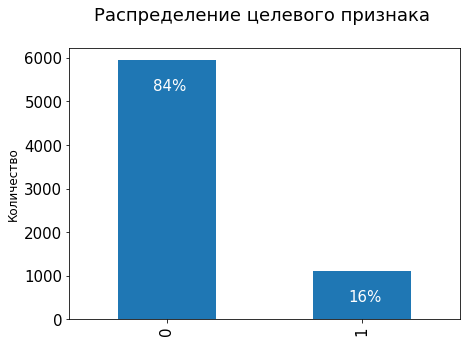

In [37]:
ax = data['сhurn'].value_counts().plot(kind='bar', figsize=(7, 5),fontsize=15);
ax.set_alpha(0.9)
ax.set_title('Распределение целевого признака \n', fontsize=18)
ax.set_ylabel("Количество", fontsize=12);

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    
    ax.text(i.get_x()+.18, i.get_height()-700,  \
            str(round((i.get_height()/total)*100))+'%', fontsize=15,
                color='white')

16% клиентов за период отказались от услуг оператора. 

Визуализируем категориальные признаки и данные по оттоку клиентов. Для этого проверим уникальные значения в некоторых признаков с типами object.

In [38]:
data.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [39]:
data.payment_method.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [40]:
data.internet_service.unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [41]:
data.multiple_lines.unique()

array(['No', 'Yes'], dtype=object)

In [42]:
# Выведем графики с заменой длинных названий на короткие по некоторым признакам

сolumns = data.columns[data.dtypes == object][:].to_list()

new_values = {'Month-to-month': 'Month', 'One year': '1Y', 'Two year': '2Y', 'Electronic check': 'ECheck', 'Mailed check': 'Mail', 'Bank transfer (automatic)': 'Bank', 'Credit card (automatic)': 'Card'}

for column in сolumns:
    data[column] = data[column].apply(lambda x: new_values[x] if x in new_values else x)

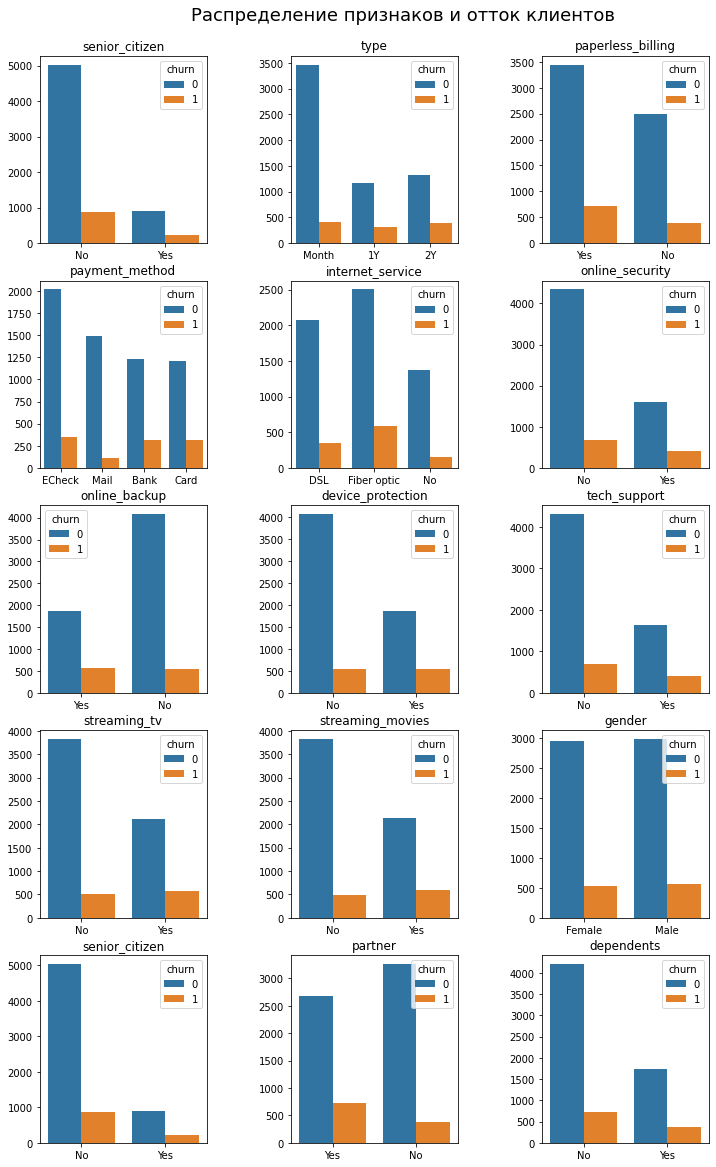

In [43]:
# Создадим основные объекты и выведем связь признаков с целевым

fig, axes = plt.subplots(5, 3, figsize=(12, 20), gridspec_kw={'wspace': 0.5})
fig.text(0.3,0.89, 'Распределение признаков и отток клиентов \n', fontstyle = "normal", fontsize = "18", fontfamily = "sans-serif");

for column, ax in zip(['senior_citizen'] + сolumns, axes.flat):
    sns.countplot(column, hue='сhurn', data=data, ax=ax).set_title(column)
    
plt.setp(axes, xlabel=None, ylabel=None)

plt.show()

Можно сделать несколько выводов. В целом, наиболее популярны ежемесячные платежи. Большинство клиентов получает чеки в электронном виде, оплата - электронный платеж. Явно заметно, что доп. услуги не являются популярными. Рассмотрев признаки с целевым можно сказать, что прослеживается линейная связь признаков с оттоков везде, за исключением gender, type, streaming_tv, streaming_movies, online_backup, device_protection.

Изучим имеющиеся количественные признаки. Создадим графики, в этом случае, уже отдельно по ушедшим и оставшимся для более точного анализа, выведем общие статистические сведения. Посмотрим какие выводы можно сделать. Сразу можно удалить ранние даты.  

In [44]:
data = data[pd.to_datetime(data.begin_date) < pd.to_datetime('2019-12-01')].reset_index(drop=True)

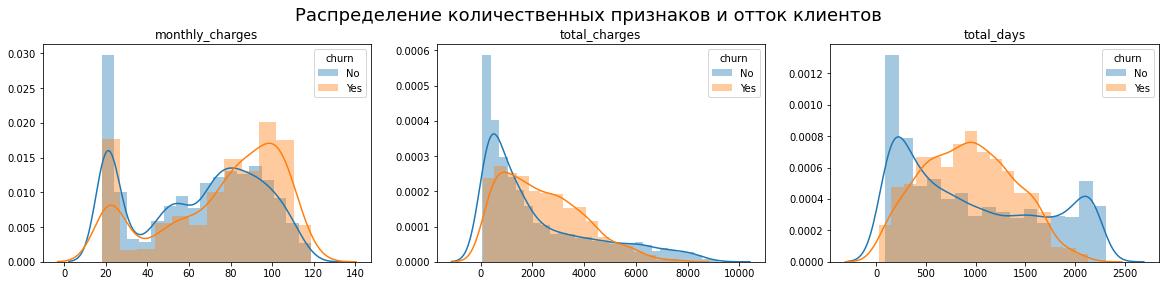

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
fig.text(0.3,0.89, 'Распределение количественных признаков и отток клиентов \n', fontstyle = "normal", fontsize = "18", fontfamily = "sans-serif");

# диаграммы
for column, ax in zip(['monthly_charges', 'total_charges', 'total_days'], axes.flat):
    sns.distplot(data.query('сhurn == 0')[column], label='No', ax=ax).set_title(column)
    sns.distplot(data.query('сhurn == 1')[column], label='Yes', ax=ax).set_title(column)
    ax.legend(loc='upper right', title='сhurn')

plt.setp(axes, xlabel=None, ylabel=None)

plt.show()

<AxesSubplot:xlabel='сhurn', ylabel='total_days'>

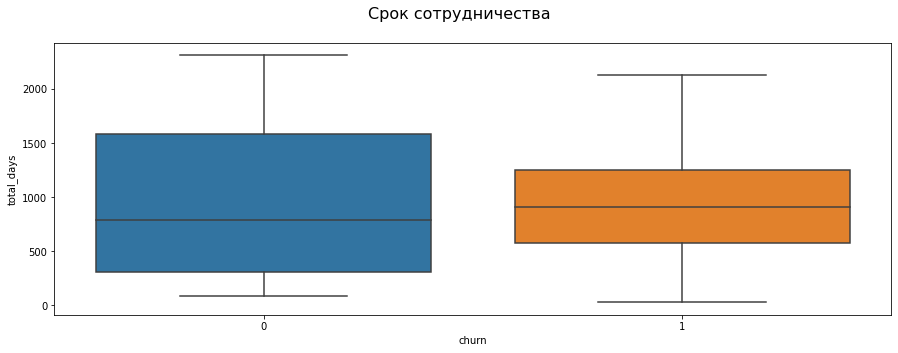

In [46]:
fig, axs = plt.subplots(figsize=(15, 5))
fig.suptitle('Срок сотрудничества', fontsize=16)
sns.boxplot(x='сhurn', y='total_days', data=data)

Нет аномальных значений. Медианная длительность договора примерно одинаковая, но у клиентов отказавшихся от сотрудничества с отператором заметны высокие траты в месяц.
Длительность договора от 0 до > 2000 дней для всех клиентов. Заключено много новых договоров. В среднем распределение общей массы ушедших клиентов ровно, представляет собой параболическую форму, основной отток от 2 лет до 3. До 2,5 лет отток увеличивается, затем постепенно снижается. Темпы ухода при достаточно длительном периоде времени начинают уменьшаться.

Проверим сводную статистику

In [47]:
display(data.query('сhurn == 0').describe())

monthly_charges  total_charges   сhurn   total_days
count      5478.000000    5478.000000  5478.0  5478.000000
mean         64.283169    2237.047307     0.0   965.569551
std          29.814616    2203.207029     0.0   700.970763
min          18.250000      56.400000     0.0    92.000000
25%          35.312500     506.547500     0.0   313.750000
50%          70.075000    1365.460000     0.0   792.000000
75%          89.300000    3441.415000     0.0  1584.000000
max         118.600000    9221.380000     0.0  2314.000000

In [48]:
display(data.query('сhurn == 1').describe())

monthly_charges  total_charges   сhurn   total_days
count      1101.000000    1101.000000  1101.0  1101.000000
mean         75.546004    2371.377275     1.0   924.863760
std          29.116213    1581.862275     0.0   458.771309
min          18.400000      77.840000     1.0    28.000000
25%          56.150000    1048.050000     1.0   577.000000
50%          84.200000    2139.030000     1.0   915.000000
75%          99.500000    3404.910000     1.0  1249.000000
max         118.750000    7649.760000     1.0  2129.000000

Проверим матрицу и распределение

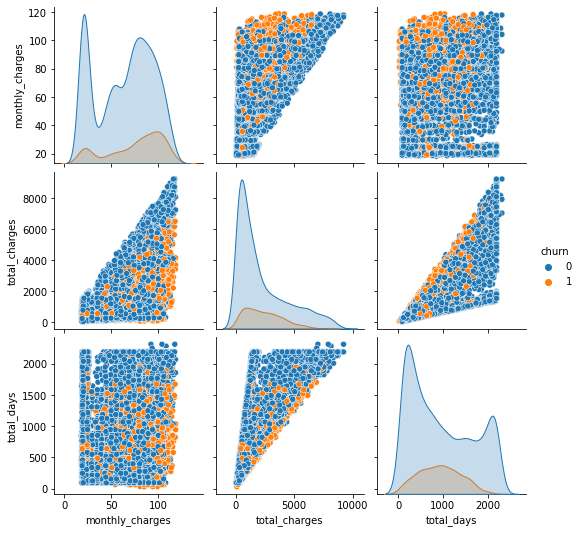

In [49]:
sns.pairplot(data, hue='сhurn');

plt.show()

Признаки tota_charges, monthly_charges, total_days имеют достаточно высокий характер силы связи.

Между признаками и оттоком клиентов существует линейная зависимость.
Признаки пола, иждивецев, семейного статуса, интернета и телефонии слабо влияют на отток.
Важно работать с признаками наиболее влияющими. Модель с большим охватом в данном случае не требуется. В дальшейшем, часть слабо влияющих признаков, исключим для обучения.

В наборе данных нет недостающих или ошибочных значений данных.
Самая сильная положительная корреляция с целевыми характеристиками - это ежемесячные платежи и длительность сотрудничества. 
Набор данных несбалансирован, и большинство клиентов являются активными.
Между ежемесячными и общими сборами существует мультиколлинеарность. 

Клиенты с ежемесячным подключением имеют очень высокую вероятность оттока и этого, если они подписались на оплату с помощью электронных чеков.

Для лучшего понимания, можно составить портрет уходящего клиента по средним данным.

In [50]:
data_lev = data[data['сhurn'] == 1]

In [51]:
data_lev.head()

begin_date   end_date   type paperless_billing payment_method  \
8  2014-12-01 2017-05-01     1Y                No           Bank   
14 2014-05-01 2016-03-01     2Y                No           Card   
24 2017-08-01 2018-09-01  Month               Yes           Bank   
29 2014-03-01 2018-11-01     2Y               Yes           Card   
31 2014-02-01 2018-12-01     2Y                No           Bank   

    monthly_charges  total_charges  сhurn internet_service online_security  \
8             56.15        1628.35      1              DSL             Yes   
14           113.25        2491.50      1      Fiber optic             Yes   
24            55.30         726.09      1              DSL             Yes   
29            96.35        5395.60      1      Fiber optic             Yes   
31            99.90        5794.20      1      Fiber optic             Yes   

    ... device_protection tech_support streaming_tv streaming_movies  gender  \
8   ...                No           No           No               No    Male   
14  ...               Yes          Yes          Yes              Yes  Female   
24  ...                No           No           No               No  Female   
29  ...               Yes          Yes           No               No  Female   
31  ...                No          Yes          Yes               No  Female   

   senior_citizen partner dependents multiple_lines total_days  
8              No      No        Yes             No        882  
14             No     Yes        Yes            Yes        670  
24             No      No         No             No        396  
29            Yes     Yes         No            Yes       1706  
31             No     Yes        Yes            Yes       1764  

[5 rows x 21 columns]

In [52]:
print('Портрет уходящего клиента:')
print('gender: ', data_lev.gender.value_counts().index[0])
print('senior_citizen: ', data_lev.senior_citizen.value_counts().index[0])
print('partner: ', data_lev.partner.value_counts().index[0])
print('dependents: ', data_lev.dependents.value_counts().index[0])
print('type: ', data_lev.type.value_counts().index[0])
print('payment_method: ', data_lev.payment_method.value_counts().index[0])
print('internet_service: ', data_lev.internet_service.value_counts().index[0])
print('monthly_charges: ', round(data_lev.monthly_charges.mean()))
print('total_charges: ', round(data_lev.total_charges.mean()))
print('total_days: ', round(data_lev.total_days.mean()))

Портрет уходящего клиента:
gender:  Male
senior_citizen:  No
partner:  Yes
dependents:  No
type:  Month
payment_method:  ECheck
internet_service:  Fiber optic
monthly_charges:  76
total_charges:  2371
total_days:  925


Портрет уходящего клиента. Мужчина, молодой, с партнером и без иждивенцев. Пользовался 2,5 года, тип оплаты ежемесячный, оплата - электронный чек. Клиент использует оптико-волоконное соединение, тратит примерно 76 уе в месяц, всего заплатил 2371 уе.

Проверим оставшегося клиента.

In [53]:
data_st = data[data['сhurn'] == 0]

In [54]:
data_st.head()

begin_date   end_date   type paperless_billing payment_method  \
0 2017-04-01 2020-02-01     1Y                No           Mail   
1 2019-10-01 2020-02-01  Month               Yes           Mail   
2 2016-05-01 2020-02-01     1Y                No           Bank   
3 2019-09-01 2020-02-01  Month               Yes         ECheck   
4 2019-03-01 2020-02-01  Month               Yes         ECheck   

   monthly_charges  total_charges  сhurn internet_service online_security  \
0            56.95        2071.84      0              DSL             Yes   
1            53.85         226.17      0              DSL             Yes   
2            42.30        1960.60      0              DSL             Yes   
3            70.70         353.50      0      Fiber optic              No   
4            99.65        1150.96      0      Fiber optic              No   

   ... device_protection tech_support streaming_tv streaming_movies  gender  \
0  ...               Yes           No           No               No    Male   
1  ...                No           No           No               No    Male   
2  ...               Yes          Yes           No               No    Male   
3  ...                No           No           No               No  Female   
4  ...               Yes           No          Yes              Yes  Female   

  senior_citizen partner dependents multiple_lines total_days  
0             No      No         No             No       1036  
1             No      No         No             No        123  
2             No      No         No             No       1371  
3             No      No         No             No        153  
4             No      No         No            Yes        337  

[5 rows x 21 columns]

In [55]:
print('Портрет оставшегося клиента:')
print('gender: ', data_st.gender.value_counts().index[0])
print('senior_citizen: ', data_st.senior_citizen.value_counts().index[0])
print('partner: ', data_st.partner.value_counts().index[0])
print('dependents: ', data_st.dependents.value_counts().index[0])
print('type: ', data_st.type.value_counts().index[0])
print('payment_method: ', data_st.payment_method.value_counts().index[0])
print('internet_service: ', data_st.internet_service.value_counts().index[0])
print('monthly_charges: ', round(data_st.monthly_charges.mean()))
print('total_charges: ', round(data_st.total_charges.mean()))
print('total_days: ', round(data_st.total_days.mean()))

Портрет оставшегося клиента:
gender:  Female
senior_citizen:  No
partner:  No
dependents:  No
type:  Month
payment_method:  ECheck
internet_service:  Fiber optic
monthly_charges:  64
total_charges:  2237
total_days:  966


Портрет уходящего клиента. Женщина, молодая, без партнера и без иждивенцев. Договор - 2,5 года, тип оплаты ежемесячный, оплата - электронный чек. Клиент использует оптико-волоконное соединение, тратит примерно 64 уе в месяц, всего заплатил 2237 уе. Средний срок сотрудничества немного больше.

Отбор признаков и проверка корелляции.

In [56]:
data.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'сhurn', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines', 'total_days'],
      dtype='object')

In [57]:
pip install phik==0.10.0

Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import phik
from phik import resources, report

In [59]:
!pip install -U scikit-learn

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'сhurn', 'total_days']


<AxesSubplot:>

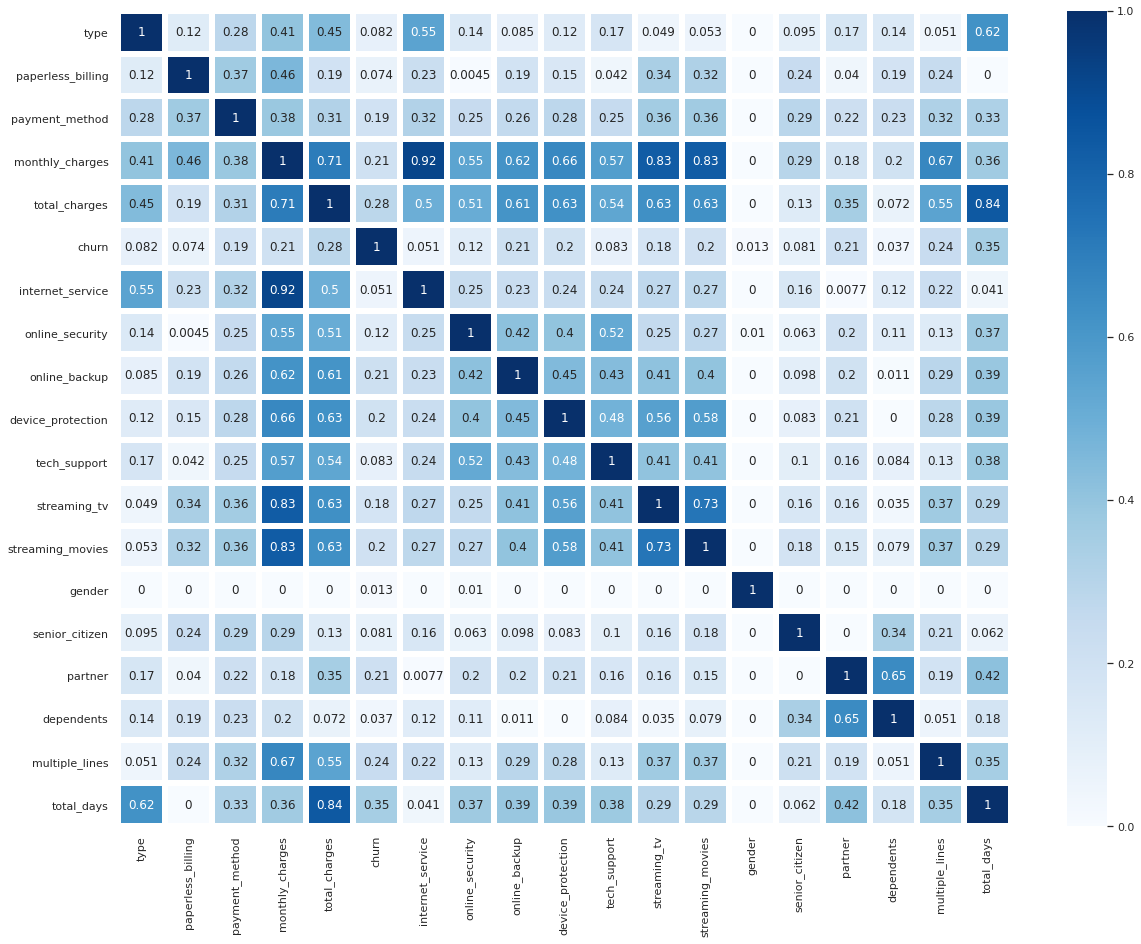

In [60]:
feature = ['type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'сhurn', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'gender', 'senior_citizen',
       'partner', 'dependents', 'multiple_lines', 'total_days']

data_phik_matrix = data[feature].phik_matrix()

sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(data_phik_matrix, linewidths=5, cmap='Blues', annot=True)

Посмотрим на признаки, которые не коррелируют с целевыми

In [61]:
tre_corr = 0.1

In [62]:
data_phik_matrix[data_phik_matrix['сhurn'] <= tre_corr]['сhurn'].sort_values(ascending = False)

tech_support         0.082798
type                 0.082340
senior_citizen       0.080808
paperless_billing    0.073811
internet_service     0.050968
dependents           0.037026
gender               0.013383
Name: сhurn, dtype: float64

Признаки streaming_tv, used_all, streaming_movies, multiple_lines иgender не являются коррелирующими с целевой функцией.

Посмотрим на признаки, которые коррелируют с целевыми

In [63]:
col_corr = data_phik_matrix[data_phik_matrix['сhurn']> tre_corr]['сhurn'].sort_values(ascending = True).index
col_corr

Index(['online_security', 'streaming_tv', 'payment_method',
       'device_protection', 'streaming_movies', 'monthly_charges', 'partner',
       'online_backup', 'multiple_lines', 'total_charges', 'total_days',
       'сhurn'],
      dtype='object')

Учтем результаты в выводах. Для обучения удалим столбцы с датами и наименее коррелирующие.

In [64]:
del data['begin_date'], data['end_date'], data['gender'], data['dependents']

In [65]:
data.head()

type paperless_billing payment_method  monthly_charges  total_charges  \
0     1Y                No           Mail            56.95        2071.84   
1  Month               Yes           Mail            53.85         226.17   
2     1Y                No           Bank            42.30        1960.60   
3  Month               Yes         ECheck            70.70         353.50   
4  Month               Yes         ECheck            99.65        1150.96   

   сhurn internet_service online_security online_backup device_protection  \
0      0              DSL             Yes            No               Yes   
1      0              DSL             Yes           Yes                No   
2      0              DSL             Yes            No               Yes   
3      0      Fiber optic              No            No                No   
4      0      Fiber optic              No            No               Yes   

  tech_support streaming_tv streaming_movies senior_citizen partner  \
0           No           No               No             No      No   
1           No           No               No             No      No   
2          Yes           No               No             No      No   
3           No           No               No             No      No   
4           No          Yes              Yes             No      No   

  multiple_lines  total_days  
0             No        1036  
1             No         123  
2             No        1371  
3             No         153  
4            Yes         337

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6579 entries, 0 to 6578
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               6579 non-null   object 
 1   paperless_billing  6579 non-null   object 
 2   payment_method     6579 non-null   object 
 3   monthly_charges    6579 non-null   float64
 4   total_charges      6579 non-null   float64
 5   сhurn              6579 non-null   int64  
 6   internet_service   6579 non-null   object 
 7   online_security    6579 non-null   object 
 8   online_backup      6579 non-null   object 
 9   device_protection  6579 non-null   object 
 10  tech_support       6579 non-null   object 
 11  streaming_tv       6579 non-null   object 
 12  streaming_movies   6579 non-null   object 
 13  senior_citizen     6579 non-null   object 
 14  partner            6579 non-null   object 
 15  multiple_lines     6579 non-null   object 
 16  total_days         6579 

In [67]:
data.corr()['сhurn'].sort_values(ascending=False)

сhurn              1.000000
monthly_charges    0.140187
total_charges      0.023739
total_days        -0.022792
Name: сhurn, dtype: float64

In [68]:
tadle = data.pivot_table(index='total_days', 
                 values='сhurn', 
                 aggfunc='sum')

In [69]:
sorted_df = tadle.sort_values(by='сhurn', ascending=False)


In [70]:
display(sorted_df.head())

сhurn
total_days       
1461           18
1035           14
153            13
792            13
1096           13

В соответствии с полученной матрицей корреляции можно сказать, что полученный набор достаточно большой. Есть много кореллирующих признаков между собой.

На матрице корреляции есть как положительные, так и отрицательные сильные связи между признаками, но с целевым признаком линейные связи очень слабые. Тем не менее, при наличии слабых корреляций между признаками и целевой переменной сохраняется возможность прогноза оттока клиентов.

В заключение можно сказать, что, влияние признаков Gender, PhoneService, MultipleLines, StreamingTV и StreamingMovies на отток клиентов минимально. Заметна и высокая корреляция месячных трат и использования интернета. Но, в данном случае, оставим признаки, т.к. набора важных признаков для обучения немного. Отток клиентов распределенный, уходят равномерно, максимальные значения зафиксированы в промежутке 3 лет.

**Вывод**

В ходе анализа признаков, анализа распределения признаков их зависимостей можно сделать следующие выводы.

- 16% клиентов за период отказались от услуг оператора.
- Наиболее популярны ежемесячные платежи. Большинство клиентов получает чеки в электронном виде, оплата - электронный платеж.
- Дополнительные услуги  не являются популярными. 
- Прослеживается линейная связь признаков с оттоком везде, за исключением gender, type, streaming_tv, streaming_movies, online_backup, device_protection.
- Медианная длительность договора примерно одинаковая (от 0 до > 2000 дней для всех клиентов).
- Затраты ушедших клиентов выше, чем у тех кто остался с оператором.
- В среднем распределение общей массы ушедших клиентов ровно, представляет собой параболическую форму, основной отток от 2 лет до 3. До 2,5 лет отток увеличивается, затем постепенно снижается. Темпы ухода при достаточно длительном периоде времени начинают уменьшаться.  
- Много новых договоров. (=живых клиентов).
- Самая сильная корреляция с целевыми характеристиками - это ежемесячные платежи и длительность сотрудничества. 
- Портрет уходящего клиента. Мужчина, молодой, с партнером и без иждивенцев. Пользовался 2,5 года, тип оплаты ежемесячный, оплата - электронный чек. Клиент использует оптико-волоконное соединение, тратит примерно 76 уе в месяц, всего заплатил 2371 уе.

В целом по итогам анализа, проведена группировка четырех датасетов. Проанализированы признаки. Произведен анализ корреляции. Выбраны признаки для обучения. произведен анализ корреляции, по которому определены и удалены не коррелирующие признаки.

## Обучение моделей

Опредилим целевой признак и разделим выборки 75/25

In [71]:
target = data['сhurn']
features = data.drop('сhurn', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)  

(4934, 16)
(1645, 16)
(4934,)
(1645,)


Закодируем катгориальные признаки OneHotEncoder

In [72]:
# категориальные признаки для OHE 
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'senior_citizen', 'partner', 'multiple_lines']


In [73]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [74]:
encoder_ohe.fit(features_train[ohe_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [75]:
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

In [76]:
features_train = features_train.drop(ohe_features, axis=1)

In [77]:
features_train.head()

monthly_charges  total_charges  total_days  type_2Y  type_Month  \
521             64.30         463.60         215      0.0         1.0   
2878            23.95         622.70         790      0.0         0.0   
6181            95.75         670.25         215      0.0         1.0   
3156            95.10         391.81         123      0.0         1.0   
756            111.20        2668.80         730      0.0         1.0   

      paperless_billing_Yes  payment_method_Card  payment_method_ECheck  \
521                     0.0                  0.0                    0.0   
2878                    0.0                  1.0                    0.0   
6181                    1.0                  0.0                    1.0   
3156                    1.0                  0.0                    1.0   
756                     1.0                  0.0                    1.0   

      payment_method_Mail  internet_service_Fiber optic  internet_service_No  \
521                   0.0                           0.0                  0.0   
2878                  0.0                           0.0                  1.0   
6181                  0.0                           1.0                  0.0   
3156                  0.0                           1.0                  0.0   
756                   0.0                           1.0                  0.0   

      online_security_Yes  online_backup_Yes  device_protection_Yes  \
521                   0.0                0.0                    1.0   
2878                  0.0                0.0                    0.0   
6181                  0.0                0.0                    1.0   
3156                  0.0                0.0                    0.0   
756                   0.0                1.0                    1.0   

      tech_support_Yes  streaming_tv_Yes  streaming_movies_Yes  \
521                1.0               1.0                   0.0   
2878               0.0               0.0                   0.0   
6181               0.0               1.0                   1.0   
3156               0.0               1.0                   1.0   
756                1.0               1.0                   1.0   

      senior_citizen_Yes  partner_Yes  multiple_lines_Yes  
521                  0.0          0.0                 0.0  
2878                 0.0          1.0                 1.0  
6181                 1.0          1.0                 0.0  
3156                 1.0          1.0                 1.0  
756                  0.0          1.0                 1.0

In [78]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

In [79]:
features_train.shape, features_test.shape

((4934, 20), (1645, 20))

In [80]:
(features_train.columns != features_test.columns).sum()

0

Будем использовать подбор со случайным поиском подбора гиперпараметров с RandomizedSearchCV. Для ускорения.

In [82]:
def models(model, parametrs, features_train, target_train):
    grid = RandomizedSearchCV(model, 
                        parametrs, 
                        cv=8,
                        random_state=RANDOM_STATE,      
                        n_iter=500,
                        n_jobs=-1, 
                        scoring='roc_auc')
    grid.fit(features_train, target_train)
    return grid.best_score_, grid.best_params_

**Модель - Random Forest Classifier**

In [84]:
%%time

pipe_rfc = Pipeline(steps= [('scaler', StandardScaler()), 
                            ('rfc', RandomForestClassifier(random_state=RANDOM_STATE, 
                                                           class_weight='balanced'))])
                
rfc_parametrs = {
     'rfc__max_depth': [4,7,10],
     'rfc__n_estimators': [10, 100, 500]

             }

rfc = models(pipe_rfc, 
             rfc_parametrs, 
             features_train, target_train)
rfc

CPU times: user 57 s, sys: 355 ms, total: 57.4 s
Wall time: 57.4 s


(0.8155026316466392, {'rfc__n_estimators': 500, 'rfc__max_depth': 7})

**Модель - LGBM Classifier**

In [86]:
pipe_lgbm = Pipeline(steps=
                    [('scaler', StandardScaler()),
                     ('lgbm', LGBMClassifier(random_state=RANDOM_STATE,
                                             objective='binary',
                                             class_weight='balanced'))])

lgbm_parametrs = {'lgbm__max_depth': [2, 8, 10],
                  'lgbm__learning_rate': [0.1, 0.5],
                  'lgbm__n_estimators': [10, 15, 20]
                 }

lgbm = models(pipe_lgbm, 
              lgbm_parametrs, 
              features_train, target_train)
lgbm

(0.8573906702347192,
 {'lgbm__n_estimators': 20, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.5})

**Модель - CatBoost Classifier**

In [85]:
%%time

pipe_cb = Pipeline(steps=
                  [('scaler', StandardScaler()),
                   ('cb', CatBoostClassifier(random_state=RANDOM_STATE,
                                             loss_function='Logloss'))])                                    
                  
cb_parametrs = {'cb__depth': [4, 7, 10],
                'cb__learning_rate' : [0.01,0.05,0.1,0.5],
                'cb__iterations'    : [10, 50, 500]
               }

cb = models(pipe_cb, 
            cb_parametrs, 
            features_train, target_train)
cb

0:	learn: 0.6869585	total: 50.9ms	remaining: 458ms
1:	learn: 0.6800487	total: 52.6ms	remaining: 211ms
2:	learn: 0.6732801	total: 54.1ms	remaining: 126ms
3:	learn: 0.6672774	total: 55.1ms	remaining: 82.6ms
4:	learn: 0.6605861	total: 56.4ms	remaining: 56.4ms
5:	learn: 0.6540995	total: 57.9ms	remaining: 38.6ms
6:	learn: 0.6474429	total: 59.2ms	remaining: 25.4ms
7:	learn: 0.6402731	total: 60.5ms	remaining: 15.1ms
8:	learn: 0.6350660	total: 61.7ms	remaining: 6.85ms
9:	learn: 0.6304854	total: 62.8ms	remaining: 0us
0:	learn: 0.6869587	total: 1.59ms	remaining: 14.3ms
1:	learn: 0.6800860	total: 3.22ms	remaining: 12.9ms
2:	learn: 0.6735396	total: 4.48ms	remaining: 10.4ms
3:	learn: 0.6682443	total: 5.27ms	remaining: 7.9ms
4:	learn: 0.6614426	total: 6.65ms	remaining: 6.65ms
5:	learn: 0.6540928	total: 7.94ms	remaining: 5.29ms
6:	learn: 0.6477583	total: 9.36ms	remaining: 4.01ms
7:	learn: 0.6415802	total: 10.7ms	remaining: 2.68ms
8:	learn: 0.6365847	total: 12ms	remaining: 1.33ms
9:	learn: 0.6309816	t

(0.9171222469706294,
 {'cb__learning_rate': 0.1, 'cb__iterations': 500, 'cb__depth': 4})

In [87]:
result = pd.DataFrame([cb[0], lgbm[0], rfc[0]], 
                       columns=['roc_auc'], 
                       index=['CatBoost',
                              'LGBM',
                              'RandomForest'])
result

roc_auc
CatBoost      0.917122
LGBM          0.857391
RandomForest  0.815503

**Вывод**

Выборка была разделены в соотношении - 75/25. Обучены 3 Модели: CatBoostClassifier, Random Forest Classifier и  LGBM Classifier
Для изучения модели и поиска наилучших гиперпараметров применен GridSearchCV и Pipeline для стандартизации функций. 

**Лучший результат метрики у модели CatBoost Classifier**
- ROC_AUC 0,91. 
- Параметры: Грубина: 4, итерации: 500, скорость обучения: 0.1.

## Тестирование модели

Протестируем модель с лучшими гиперпараметрами модели

In [88]:
best_model = CatBoostClassifier(random_state=RANDOM_STATE, depth=4, iterations=500, learning_rate=0.1, loss_function='Logloss')

best_model.fit(features_train, target_train)
predict_proba = best_model.predict_proba(features_test)[:, 1]
roc_auc_cb = round(roc_auc_score(target_test, predict_proba), 3)

0:	learn: 0.6317519	total: 1.81ms	remaining: 902ms
1:	learn: 0.5757145	total: 3.56ms	remaining: 887ms
2:	learn: 0.5348052	total: 5.09ms	remaining: 843ms
3:	learn: 0.5046891	total: 6.75ms	remaining: 837ms
4:	learn: 0.4770550	total: 8.35ms	remaining: 827ms
5:	learn: 0.4522632	total: 9.99ms	remaining: 823ms
6:	learn: 0.4334997	total: 11.6ms	remaining: 816ms
7:	learn: 0.4233605	total: 13.7ms	remaining: 843ms
8:	learn: 0.4114066	total: 15.8ms	remaining: 860ms
9:	learn: 0.4036725	total: 17.7ms	remaining: 866ms
10:	learn: 0.3955940	total: 19.7ms	remaining: 874ms
11:	learn: 0.3890350	total: 21.7ms	remaining: 883ms
12:	learn: 0.3840844	total: 24.5ms	remaining: 918ms
13:	learn: 0.3798188	total: 26.2ms	remaining: 909ms
14:	learn: 0.3746621	total: 28.5ms	remaining: 923ms
15:	learn: 0.3712971	total: 30.5ms	remaining: 922ms
16:	learn: 0.3678462	total: 32.4ms	remaining: 919ms
17:	learn: 0.3650462	total: 33.8ms	remaining: 904ms
18:	learn: 0.3627647	total: 35.4ms	remaining: 897ms
19:	learn: 0.3597942	t

In [89]:
print(roc_auc_cb)

0.923


Показатель на тестовой выборке 0.923. Т.е. ROC_AUC >= 0.85 достигнут.

Построим кривую ROC-curve

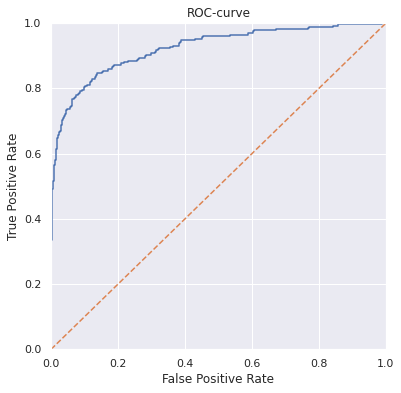

In [90]:
fpr, tpr, thresholds = roc_curve(target_test, predict_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.plot([0, 2], [0, 2], linestyle='--')
plt.show() 

Модель имеет высокую AUC, с большой площадью под кривой, что указывает на правильную классификацию наблюдений по признакам.

Метрика Accuracy

In [91]:
predicted_test = best_model.predict(features_test) 
acc_cb = round(accuracy_score(target_test, predicted_test), 2)

In [92]:
print(acc_cb)

0.92


Построим марицу ошибок и проверим результаты правильных и ложных ответов модели

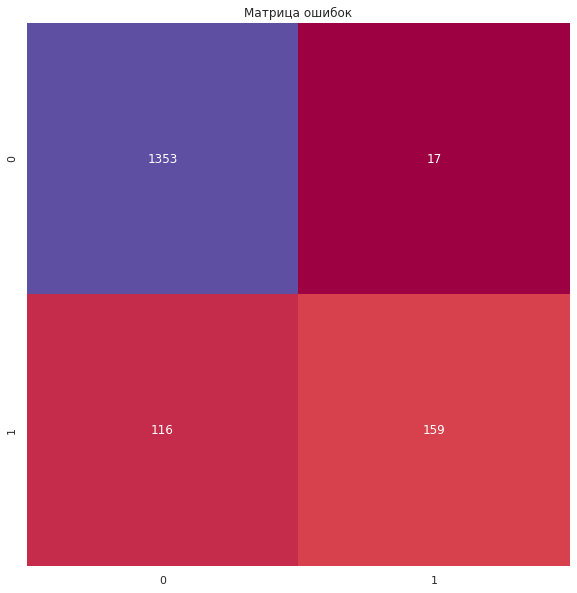

In [93]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(target_test, predicted_test), annot = True,  cmap= 'Spectral', cbar=False, square=True, fmt='1.0f')
plt.title('Матрица ошибок');

Модель отметила ложноположительный результат 17 раз и FN ложноотрицательный результат 116 раз. Положительный ответ -  1353 раза. Модель достаточно качественная. Recall -  0,92 and Precision 0,98.

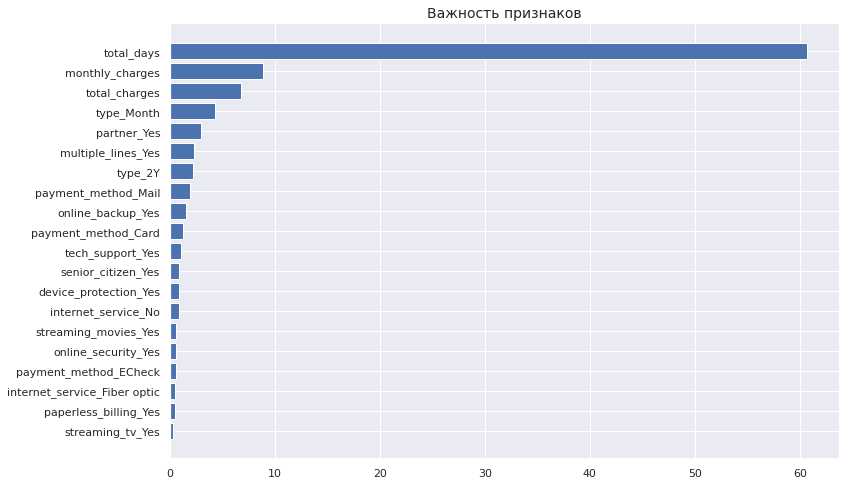

In [94]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='b')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Важность признаков', fontsize = 14);

Признак длительности сотрудничества действительно оказался наиболее весомым. Ежемесячные платежи и общая сумма платежей также оказывают сильное влияние на модель. Остальные признаки имеют меньшую важность.

**Вывод**

- Результат проверен (predict_proba) на тестовой выборке. Показатель 0,923. 
- Построена матрица ошибок. Модель отметила ложноположительный результат 17 раз и FN ложноотрицательный результат 116 раз. Положительный ответ - 1353 раза. Модель достаточно качественная. Recall - 0,92 and Precision 0,98.
- Проанализировав признаки важности для предстазания и обучения модели можно сделать вывод, что длительность сотрудничества действительно наиболее весомый фактор. Ежемесячные платежи и общая сумма платежей также оказывают сильное влияние на модель. Остальные признаки имеют меньшую важность.

## Результаты и общие выводы. Отчет

Основной целью проекта был **прогноз оттока клиентов оператора связи «Ниединогоразрыва.ком»**, для их удержания (предложения промокодов и специальных условий) в последующем.

Для этого была необходима **разработка прототипа модели, которая подскажет, с кем из клиентов следует поработать над удержанием**. 

В ходе проделанной работы были выполнены следующие шаги:

- Составлен план проекта.
- Загружены и изучены данные.
- На этапе предобработки преобразованы названия признаков, столбцов, приведены данные  BeginDate, EndDate, TotalCharges к нужным типам. 
- Добавлено 2 новых стобеца **сhurn** - отток абонентов, который является целевым признаком (Т.е. важны зафиксированные данные факта ухода клиента от оператора: 1 клиент ушел, 0 - клиент все еще пользуется услугами) и столбец с расчетом длительности сотрудничества - **total_days** (признак и для дальнейшего обучения и для исследования взаимосвязи имеющихся признаков). 
- Удалены begin_date и end_date.
- Данные проверены на выбросы и аномалии.
- Объединены данные по договорам и услугам методом .merge().

В целом, компания предоставляет несколько основных видов услуг и несколько дополнительных: Стационарная связь, Интернет и 
услуги Интернет-безопасности, Выделенную линию технической поддержки, Облачное хранилище файлов и резервное копирование данных 
Потоковое телевидение и каталог фильмов соответственно. Оплата - ежемесячный платеж/год/два. В ходе иследовательского анализа распределения и взаимодействия признаков были сделаны следующие выводы:

- Дополнительные услуги не пользуются популярностью у клиентов оператора. 
- Процент отток средний - 16% клиентов за период.
- Наиболее популярны ежемесячные платежи. Большинство клиентов получает чеки в электронном виде, оплата - электронный платеж.
- Прослеживается линейная связь признаков с оттоком везде, за исключением gender, type, streaming_tv, streaming_movies, online_backup, device_protection.
- Затраты ушедших клиентов выше, чем у тех кто остался с оператором.
- В среднем распределение общей массы ушедших клиентов ровно, представляет собой параболическую форму, основной отток от 2 лет до 3. До 2,5 лет отток увеличивается, затем постепенно снижается. Темпы ухода при достаточно длительном периоде времени начинают уменьшаться.  
- Много новых договоров. (=живых клиентов).

<a href="https://ibb.co/bdJSvff"><img src="https://i.ibb.co/C02k9rr/image.png" alt="image" border="0"></a>

Для разработки прототипа модели и получения результирующей мерики с показателем ROC_AUC >= 0.85 были обучены три модели: **CatBoostClassifier, Random Forest Classifier и LGBM Classifier** Для поиска наилучших гиперпараметров применен RandomizedSearchCV (cv=8, заданный random_state=RANDOM_STATE,  500 итераций и Pipeline для стандартизации функций (измеряем и показатель точности Accuracy)

Лучший результат метрики у модели **CatBoost Classifier**

- ROC_AUC 0,91.
- Параметры: Грубина: 4, итерации: 500, скорость обучения: 0.1.

По точности метрика Accuracy по кол-ву правильных прогнозов достигла 0,92. По визуализации ROC кривой можно сделать выводы, что  модель имеет высокую вероятность предсказвия и правильной классификации: **Модель отметила ложноположительный результат 17 раз и FN ложноотрицательный результат 116 раз. Положительный ответ -  1353 раза. Модель достаточно качественная. Recall -  0,92 and Precision 0,98.**

<img src="https://imgbb.su/images/2023/06/01/AUKa354fedd84886cc6.png" alt="Аук" border="0">

Проанализировав принаки был сделан вывод, что признак длительности сотрудничества - наиболее весомый для прогноза оттока клиентов. Ежемесячные платежи и общая сумма платежей также оказывают сильное влияние на модель. Остальные признаки имеют меньшую важность.

<img src="https://imgbb.su/images/2023/06/01/VAZNOST-PRIZNAKOVfee306a3c80b482f.png" alt="Важность признаков" border="0">

В целом по бизнесу можно сказать, что изучив распределение оттока клиентов и взаимосвязь с признаками особое внимание необходимо уделить внимание клиентам, которые сотрудничают с оператором до 2,5 лет и ежемесячно тратят на услуги сумму на более чем 15% превышающую сумму оставшихся клиентов (расход). Для предотвращения оттока таких клиентов возможно ввести новый пакет услуг, предложить программы лояльности, оптимизировать договоры и предложить новые варианты оплаты услуг.
